In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import pickle

import tensorflow as tf

2025-05-16 12:29:08.212288: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 12:29:08.232372: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_array(load_path):
    with open(load_path, 'rb') as file:
        return pickle.load(file)

In [3]:
# Load data
x_data = load_array('data/x_train.pkl')
y_data = load_array('data/y_train.pkl')

# Ensure same length
assert len(x_data) == len(y_data)

# Train/test split (e.g., 80/20)
split_idx = int(len(x_data) * 0.8)

x_train = x_data[:split_idx]
y_train = y_data[:split_idx]

x_test = x_data[split_idx:]
y_test = y_data[split_idx:]


In [4]:
print(x_train)
print(y_train)

print(x_test)
print(y_test)

["absolutely terrible movie. lured christopher walken michael ironside. great actors, must simply worst role history. even great acting could redeem movie's ridiculous storyline. movie early nineties us propaganda piece. pathetic scenes columbian rebels making cases revolutions. maria conchita alonso appeared phony, pseudo-love affair walken nothing pathetic emotional plug movie devoid real meaning. disappointed movies like this, ruining actor's like christopher walken's good name. could barely sit it."
 'known fall asleep films, usually due combination things including, really tired, warm comfortable sette eaten lot. however occasion fell asleep film rubbish. plot development constant. constantly slow boring. things seemed happen, explanation causing why. admit, may missed part film, watched majority everything seemed happen accord without real concern anything else. cant recommend film all.'
 'mann photographs alberta rocky mountains superb fashion, jimmy stewart walter brennan give 

In [5]:
# Parameters
vocab_size = 20000  # Maximum number of unique tokens
max_length = 250    # Maximum length of sequences after padding

# Initialize TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_length
)

# Prepare the layer with the training data
# 'x_train' should be a dataset or a list/array of strings
vectorize_layer.adapt(x_train)

# Convert text data to integer sequences
x_train = vectorize_layer(x_train)
x_test = vectorize_layer(x_test)

x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

print(x_train)
print(y_train)

tf.Tensor(
[[3.190e+02 2.830e+02 3.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [5.310e+02 6.910e+02 2.304e+03 ... 0.000e+00 0.000e+00 0.000e+00]
 [4.203e+03 5.990e+03 1.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [5.130e+02 1.200e+01 1.600e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.570e+02 1.294e+03 3.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.780e+03 4.000e+00 1.461e+03 ... 0.000e+00 0.000e+00 0.000e+00]], shape=(20000, 250), dtype=float32)
[0 0 0 ... 0 0 0]


In [6]:
print(y_train.dtype)
print(y_train[:5])

int64
[0 0 0 1 1]


In [7]:
x_train.shape

TensorShape([20000, 250])

In [8]:
from tensorflow import keras
from keras import layers

# Define Model Parameters
embedding_dim = 128
lstm_units = 128

# Create the Model
model = keras.Sequential([
    layers.Embedding(input_dim=20000, output_dim=embedding_dim, input_length=250),
    layers.LSTM(lstm_units, return_sequences=False),  # Simple LSTM layer
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, 250))  # Manually build the model
model.summary()

/home/pitangura/miniconda3/envs/movie_reviews/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,699,905 (10.30 MB)

 Trainable params: 2,699,905 (10.30 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

savename = "models/deep.keras"

# Early stopping monitors validation loss
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

# Model checkpoint saves the best weights based on validation loss
mc = ModelCheckpoint(
    filepath=savename,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

In [10]:
num_epochs = 100
hist = model.fit(x_train,
                 y_train,
                 epochs = num_epochs,
                 batch_size = 32,
                 validation_data = (x_test, y_test),
                 callbacks = [es, mc])

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5053 - loss: 0.6938
Epoch 1: val_loss improved from inf to 0.70109, saving model to models/deep.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.5053 - loss: 0.6938 - val_accuracy: 0.5070 - val_loss: 0.7011
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5185 - loss: 0.6816
Epoch 2: val_loss improved from 0.70109 to 0.68927, saving model to models/deep.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.5186 - loss: 0.6816 - val_accuracy: 0.5146 - val_loss: 0.6893
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5572 - loss: 0.6319
Epoch 3: val_loss did not improve from 0.68927
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.5572 - loss: 0.6319 - val_accuracy: 0.5140 - val_loss: 0.7194
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5585 - loss: 0.6234
Epoch 4: val_loss did not improve from 0.68927
625/625 ━━━━━━━━━━━━━━━━━━━━ 

782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step


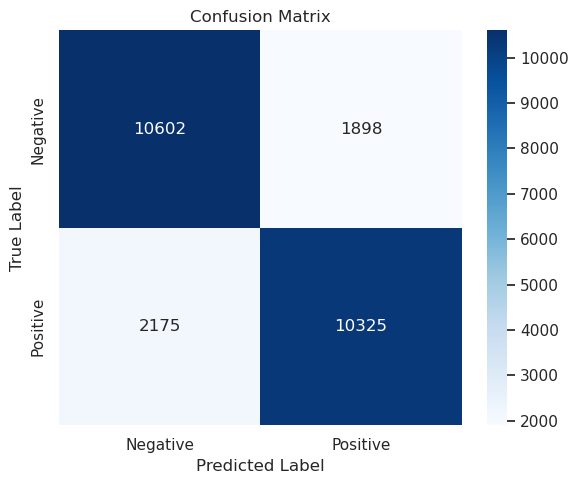

In [14]:
# Load data
x_test = load_array('data/x_test.pkl')
y_test = load_array('data/y_test.pkl')

# Apply the same vectorization layer you used for training
x_test = vectorize_layer(x_test)

# (Optional) Cast to float32 if needed
x_test = tf.cast(x_test, tf.float32)

# Predict probabilities
y_pred_probs = model.predict(x_test)

# Convert to binary predictions
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
y_true = y_test.flatten()

# Initialize confusion matrix
conf_matrix = np.zeros((2, 2), dtype=int)

# Fill confusion matrix manually
for true, pred in zip(y_true, y_pred):
    conf_matrix[int(true), int(pred)] += 1

# Plot
labels = ['Negative', 'Positive']
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

plt.savefig('conf')

<Figure size 640x480 with 0 Axes>

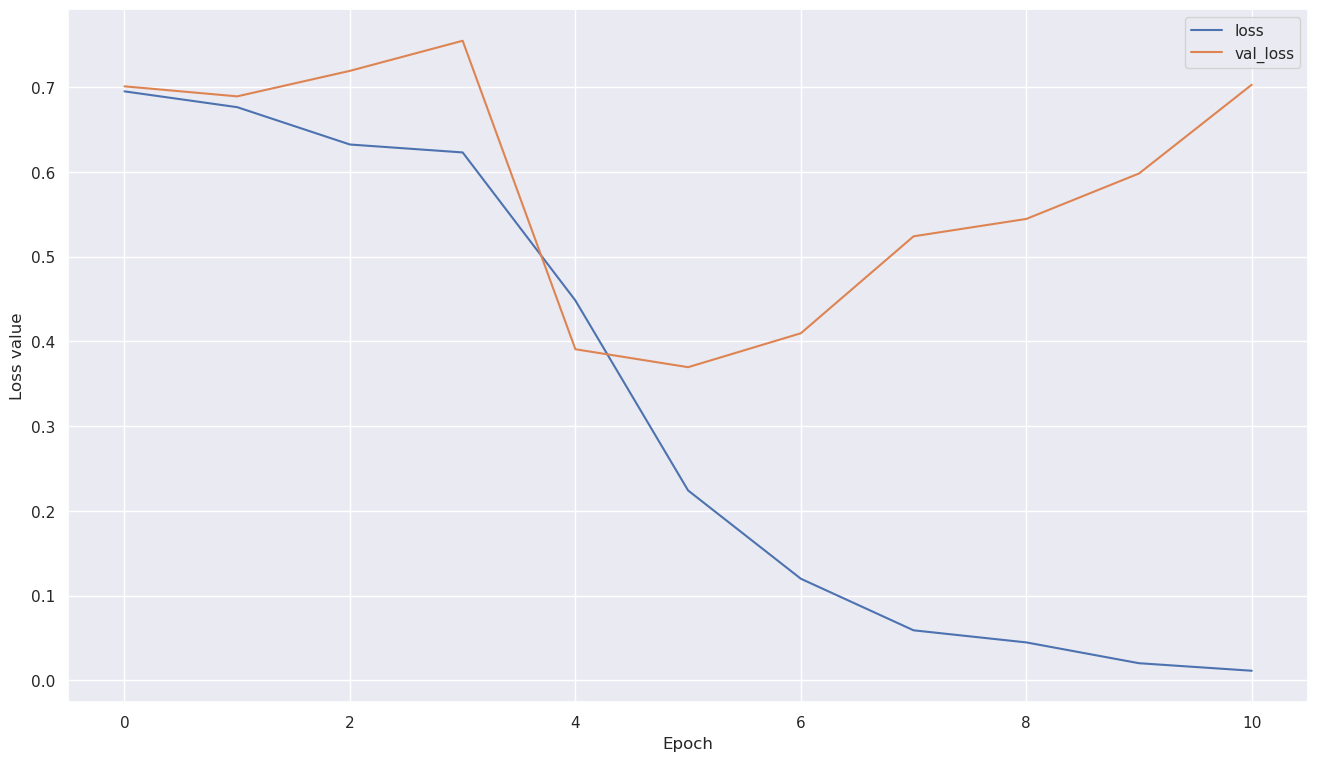

In [15]:
plt.figure(figsize = (16, 9))
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend(loc = 'best')

plt.show()
plt.savefig('loss')

<Figure size 640x480 with 0 Axes>

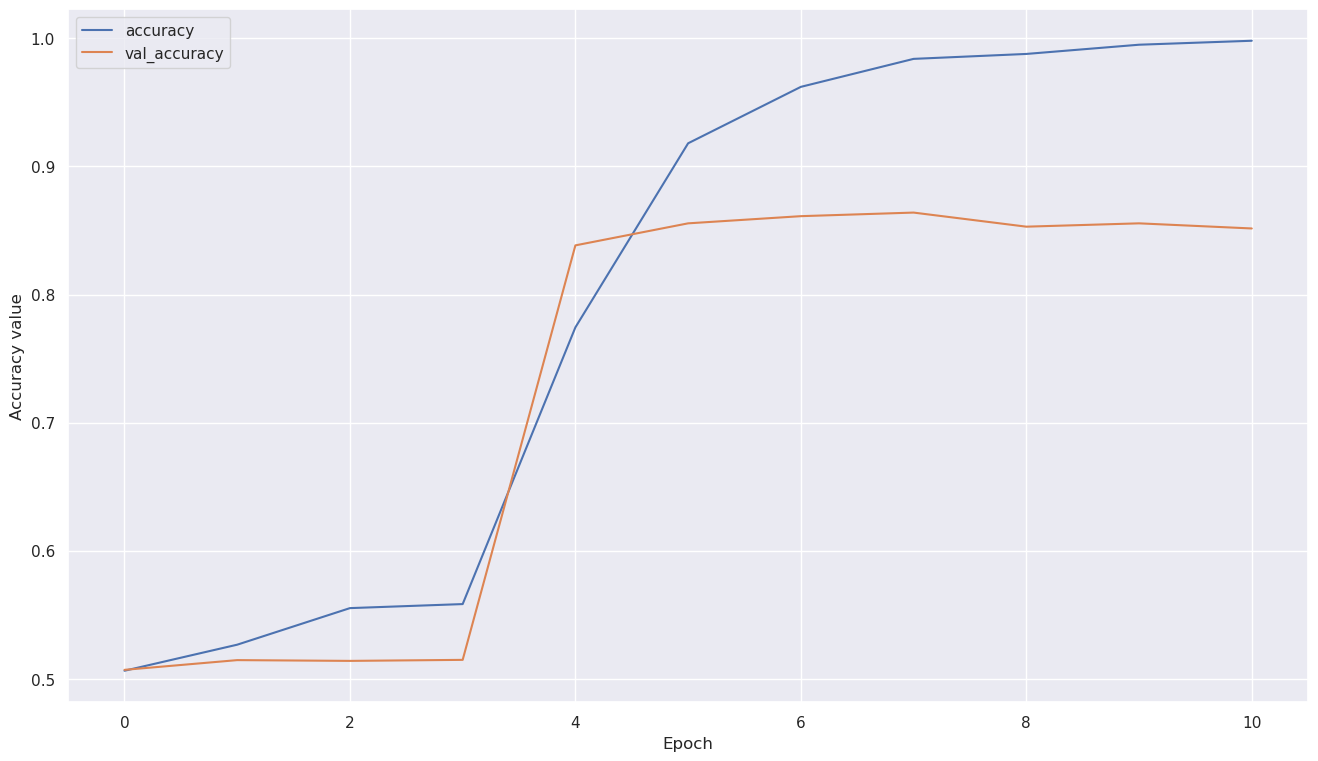

In [16]:
plt.figure(figsize = (16, 9))
plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.legend(loc = 'best')

plt.show()
plt.savefig('acc')